<a href="https://colab.research.google.com/github/Yasmin638/Advanced-Time-Series-Forecasting-with-Prophet-and-Neural-Networks/blob/main/Advanced_Time_Series_Forecasting_with_Prophet_and_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:

# Cell 1: Install / upgrade packages (run first)
!pip install -q --upgrade prophet cmdstanpy pandas numpy scikit-learn matplotlib tensorflow tqdm
print("Requested package installs/upgrades (prophet, cmdstanpy, pandas, numpy, scikit-learn, matplotlib, tensorflow, tqdm).")


Requested package installs/upgrades (prophet, cmdstanpy, pandas, numpy, scikit-learn, matplotlib, tensorflow, tqdm).


In [41]:
# Cell 2: Install (or re-install) CmdStan programmatically (no heredoc)
# This downloads CmdStan and may take a few minutes.
import cmdstanpy, os
cmdstanpy.install_cmdstan(overwrite=True)
print("CmdStan installed to:", cmdstanpy.cmdstan_path())
# Set CMDSTAN environment variable for this session
os.environ['CMDSTAN'] = cmdstanpy.cmdstan_path()
print("CMDSTAN env set to:", os.environ['CMDSTAN'])


CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmpd84sw9vf
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.
Overwrite requested, remove existing build of version cmdstan-2.37.0
Rebuilding version cmdstan-2.37.0
Installed cmdstan-2.37.0
Test model compilation
CmdStan installed to: /root/.cmdstan/cmdstan-2.37.0
CMDSTAN env set to: /root/.cmdstan/cmdstan-2.37.0


In [42]:
# Cell 3: Run this AFTER restarting the runtime
import os, cmdstanpy
print("cmdstanpy version:", cmdstanpy.__version__)
print("cmdstan path:", cmdstanpy.cmdstan_path())
print("CMDSTAN env:", os.environ.get('CMDSTAN'))

# Try instantiate Prophet explicitly using CMDSTANPY backend
try:
    from prophet import Prophet
    m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True, stan_backend='CMDSTANPY')
    print("Prophet instantiation OK with CMDSTANPY.")
except Exception as e:
    print("Prophet instantiation FAILED:", type(e).__name__, e)
    raise



cmdstanpy version: 1.3.0
cmdstan path: /root/.cmdstan/cmdstan-2.37.0
CMDSTAN env: /root/.cmdstan/cmdstan-2.37.0
Prophet instantiation OK with CMDSTANPY.


In [43]:
# Cell 4: Imports + helpers
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Path to your uploaded image
screenshot_url = '/mnt/data/e11c7990-f2ad-4b6d-a9ab-43bfa7b1c230.png'
print("Using image:", screenshot_url)

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


Using image: /mnt/data/e11c7990-f2ad-4b6d-a9ab-43bfa7b1c230.png


In [44]:
# Cell 5: Synthetic data generation
def generate_synthetic_series(n_days=3*365 + 150, seed=42):
    np.random.seed(seed)
    ds = pd.date_range(start='2017-01-01', periods=n_days, freq='D')
    t = np.arange(n_days)
    trend = 0.02 * t
    yearly = 12 * np.sin(2 * np.pi * t / 365.25)
    weekly = 3.0 * np.sin(2 * np.pi * t / 7.0)
    price_change = 2.5 * np.sin(2 * np.pi * t / 180.0) + 0.5 * np.random.randn(n_days)
    holiday_indicator = np.zeros(n_days)
    for start in range(0, n_days, 90):
        idx = start + np.random.randint(0, 10)
        if idx < n_days:
            holiday_indicator[idx: min(n_days, idx+3)] = 1.0
    exog_effect = 0.9 * price_change + 4.0 * holiday_indicator
    noise = 2.0 * np.random.randn(n_days)
    y = 100 + trend + yearly + weekly + exog_effect + noise
    df = pd.DataFrame({'ds': ds, 'y': y, 'price_change': price_change, 'holiday_indicator': holiday_indicator})
    return df

df = generate_synthetic_series()
print("Rows:", len(df))
df.head()


Rows: 1245


,ds,y,price_change,holiday_indicator
0,2017-01-01,97.775641,0.248357,0.0
1,2017-01-02,103.978214,0.018117,0.0
2,2017-01-03,107.719058,0.498235,0.0
3,2017-01-04,106.380219,1.022836,1.0
4,2017-01-05,107.264852,0.230856,1.0


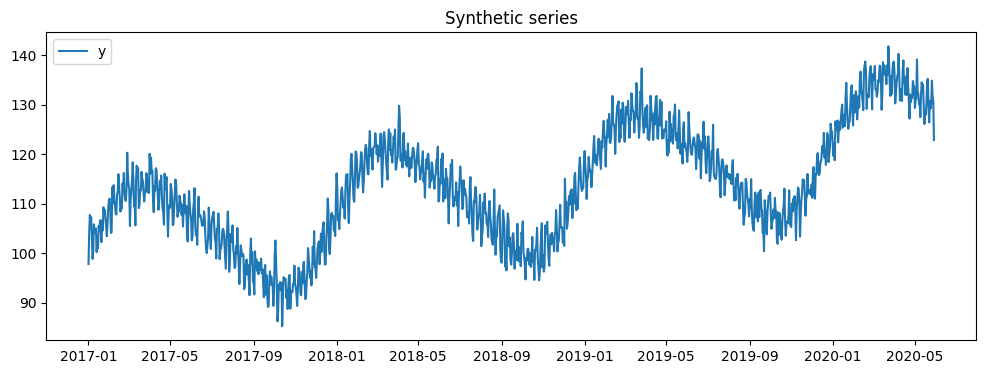

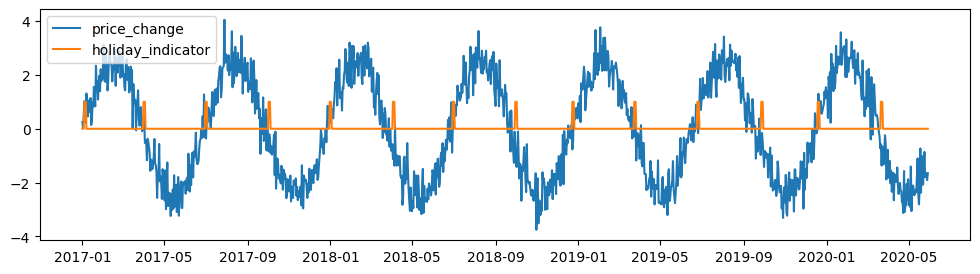

In [45]:
# Cell 6: quick visual check
plt.figure(figsize=(12,4))
plt.plot(df['ds'], df['y'], label='y')
plt.title('Synthetic series')
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(df['ds'], df['price_change'], label='price_change')
plt.plot(df['ds'], df['holiday_indicator'], label='holiday_indicator')
plt.legend()
plt.show()



In [46]:
# Cell 7: fit/predict with Prophet (robust to backend issues)
def fit_predict_prophet(train_df, test_df, regressor_cols=['price_change','holiday_indicator'], params=None):
    try:
        from prophet import Prophet
    except Exception as e:
        raise ImportError("Prophet not installed or failed to import. Ensure you've run install and restarted runtime.") from e

    if params is None:
        params = {}

    # Try normal instantiate; if AttributeError occurs, try specifying CMDSTANPY explicitly.
    try:
        m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True,
                    changepoint_prior_scale=params.get('changepoint_prior_scale', 0.05),
                    seasonality_prior_scale=params.get('seasonality_prior_scale', 10.0))
    except AttributeError:
        # explicit backend - works after cmdstanpy.install_cmdstan(overwrite=True) and restart
        m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True,
                    changepoint_prior_scale=params.get('changepoint_prior_scale', 0.05),
                    seasonality_prior_scale=params.get('seasonality_prior_scale', 10.0),
                    stan_backend='CMDSTANPY')

    # Add regressors if present
    for r in regressor_cols:
        if r in train_df.columns:
            m.add_regressor(r)

    cols = ['ds','y'] + [r for r in regressor_cols if r in train_df.columns]
    m.fit(train_df[cols])

    future_cols = ['ds'] + [r for r in regressor_cols if r in test_df.columns]
    future = test_df[future_cols]
    fc = m.predict(future)
    return fc['yhat'].values



In [48]:
# Cell 8 (REPLACE existing LSTM helpers with this cell)

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import backend as K

def create_sequences(values, exogs=None, window=30):
    """
    values: 1d array-like of target values
    exogs: 2D array-like (n_samples, n_exog) aligned with values OR None
    returns: X_seq (samples, window), X_exog (samples, n_exog) or None, y (samples,)
    """
    X_seq, X_exog, y = [], [], []
    n = len(values)
    for i in range(window, n):
        X_seq.append(values[i-window:i])
        y.append(values[i])
        if exogs is not None:
            X_exog.append(exogs[i])   # exog at time i (current-step) aligns with target y[i]
    X_seq = np.array(X_seq)
    y = np.array(y)
    X_exog = np.array(X_exog) if exogs is not None else None
    return X_seq, X_exog, y

def build_lstm_model(window=30, n_exog=0, units=32, dropout=0.1, lr=0.001):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate

    seq_in = Input(shape=(window,1), name='seq_in')
    x = LSTM(units)(seq_in)
    x = Dropout(dropout)(x)

    if n_exog > 0:
        exog_in = Input(shape=(n_exog,), name='exog_in')
        x = Concatenate()([x, exog_in])
        out = Dense(1)(x)
        model = Model(inputs=[seq_in, exog_in], outputs=out)
    else:
        out = Dense(1)(x)
        model = Model(inputs=seq_in, outputs=out)

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

def train_predict_lstm(train_df, test_df, window=30, epochs=10, batch_size=32, units=32, dropout=0.1, lr=0.001):

    # scale target using MinMaxScaler
    scaler_y = MinMaxScaler()
    y_train = train_df['y'].values.reshape(-1,1)
    scaler_y.fit(y_train)
    # get exogs if available
    exog_cols = ['price_change','holiday_indicator']
    exogs_train = train_df[exog_cols].values if all(c in train_df.columns for c in exog_cols) else None

    # create sequences aligned with exog (if present)
    X_seq, X_exog, y_seq = create_sequences(train_df['y'].values, exogs_train, window=window)

    # sanity check: lengths must match
    assert X_seq.shape[0] == y_seq.shape[0], "Sequence and target length mismatch after create_sequences."

    # scale sequences (fit on flattened training window values)
    scaler_x = MinMaxScaler()
    flat = X_seq.reshape(-1,1)
    scaler_x.fit(flat)
    X_seq_s = scaler_x.transform(flat).reshape(X_seq.shape[0], X_seq.shape[1], 1)
    y_seq_s = scaler_y.transform(y_seq.reshape(-1,1)).flatten()

    n_exog = X_exog.shape[1] if X_exog is not None else 0

    model = build_lstm_model(window=window, n_exog=n_exog, units=units, dropout=dropout, lr=lr)

    # Fit model — IMPORTANT: pass X_exog (no extra slicing) so cardinalities match
    if n_exog == 0:
        model.fit(X_seq_s, y_seq_s, epochs=epochs, batch_size=batch_size, verbose=0)
    else:
        # X_exog already has shape (n_samples, n_exog) where n_samples == X_seq_s.shape[0]
        if X_exog.shape[0] != X_seq_s.shape[0]:
            raise ValueError(f"Exog samples ({X_exog.shape[0]}) do not match sequence samples ({X_seq_s.shape[0]}).")
        model.fit([X_seq_s, X_exog], y_seq_s, epochs=epochs, batch_size=batch_size, verbose=0)

    # Rolling forecast: iterative one-step-ahead using expanding history
    history = list(train_df['y'].values)
    preds = []

    # If exog present for test, ensure test_df has required exog columns
    exog_available = all(c in test_df.columns for c in exog_cols)

    for t in range(len(test_df)):
        seq_in = np.array(history[-window:]).reshape(1,window,1)
        seq_in_s = scaler_x.transform(seq_in.reshape(-1,1)).reshape(1,window,1)
        if n_exog > 0 and exog_available:
            # use test exog at step t (current-step exog aligns with the step we predict)
            exog_input = np.array([test_df[exog_cols].values[t]])
            p_s = model.predict([seq_in_s, exog_input], verbose=0).flatten()
        else:
            p_s = model.predict(seq_in_s, verbose=0).flatten()
        p = scaler_y.inverse_transform(p_s.reshape(-1,1)).flatten()[0]
        preds.append(p)
        # append true observed y to history to simulate expanding window
        history.append(test_df['y'].values[t])

    # clear session to avoid memory build-up if running many times
    K.clear_session()
    return np.array(preds)




In [49]:
# Cell 9: rolling-origin CV
def rolling_origin_cv(df, model_type='prophet', n_splits=4, initial_train=365, test_size=90, **model_kwargs):
    results = []
    n = len(df)
    for split in range(n_splits):
        train_end = initial_train + split * test_size
        test_start = train_end
        test_end = test_start + test_size
        if test_end > n:
            break
        train_df = df.iloc[:train_end].reset_index(drop=True)
        test_df = df.iloc[test_start:test_end].reset_index(drop=True)

        if model_type == 'prophet':
            yhat = fit_predict_prophet(train_df, test_df, regressor_cols=['price_change','holiday_indicator'], params=model_kwargs.get('prophet_params'))
        elif model_type == 'lstm':
            yhat = train_predict_lstm(train_df, test_df, window=model_kwargs.get('window',30), epochs=model_kwargs.get('epochs',8), batch_size=model_kwargs.get('batch_size',32), units=model_kwargs.get('units',32), dropout=model_kwargs.get('dropout',0.1), lr=model_kwargs.get('lr',0.001))
        else:
            raise ValueError('Unknown model_type')

        mae_v = mean_absolute_error(test_df['y'].values, yhat)
        rmse_v = rmse(test_df['y'].values, yhat)
        mape_v = mape(test_df['y'].values, yhat)
        results.append({'split': split, 'train_end': train_end, 'test_end': test_end, 'mae': mae_v, 'rmse': rmse_v, 'mape': mape_v})
        print(f"[{model_type.upper()}] split={split} MAE={mae_v:.4f} RMSE={rmse_v:.4f} MAPE={mape_v:.2f}%")
    return pd.DataFrame(results)


In [50]:
# Cell 10: hyperparameter grids (small for speed)
prophet_grid = [
    {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0},
    {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}
]

lstm_grid = [
    {'units': 16, 'dropout': 0.1, 'lr': 0.001, 'epochs': 6},
    {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'epochs': 8}
]

print("Prophet grid:", prophet_grid)
print("LSTM grid:", lstm_grid)


Prophet grid: [{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0}, {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}]
LSTM grid: [{'units': 16, 'dropout': 0.1, 'lr': 0.001, 'epochs': 6}, {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'epochs': 8}]


In [51]:
# Cell 11: CV over Prophet grid
prophet_results_all = []
for params in prophet_grid:
    print("\nTesting Prophet params:", params)
    res = rolling_origin_cv(df, model_type='prophet', n_splits=3, initial_train=365, test_size=90, prophet_params=params)
    avg_rmse = res['rmse'].mean()
    prophet_results_all.append({'params': params, 'cv': res, 'avg_rmse': avg_rmse})
best_prophet = min(prophet_results_all, key=lambda x: x['avg_rmse'])
print("\nBest Prophet params:", best_prophet['params'], "avg_rmse=", best_prophet['avg_rmse'])



Testing Prophet params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0}
[PROPHET] split=0 MAE=1.4300 RMSE=1.8109 MAPE=1.21%
[PROPHET] split=1 MAE=1.6529 RMSE=2.1392 MAPE=1.43%
[PROPHET] split=2 MAE=1.9543 RMSE=2.3769 MAPE=1.87%

Testing Prophet params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}
[PROPHET] split=0 MAE=2.0022 RMSE=2.3964 MAPE=1.69%
[PROPHET] split=1 MAE=1.6533 RMSE=2.1423 MAPE=1.43%
[PROPHET] split=2 MAE=1.9212 RMSE=2.3370 MAPE=1.83%

Best Prophet params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0} avg_rmse= 2.109004779566685


In [52]:
# Cell 12: CV over LSTM grid
lstm_results_all = []
for cfg in lstm_grid:
    print("\nTesting LSTM cfg:", cfg)
    res = rolling_origin_cv(df, model_type='lstm', n_splits=3, initial_train=365, test_size=90, window=30, epochs=cfg['epochs'], batch_size=32, units=cfg['units'], dropout=cfg['dropout'], lr=cfg['lr'])
    avg_rmse = res['rmse'].mean()
    lstm_results_all.append({'cfg': cfg, 'cv': res, 'avg_rmse': avg_rmse})
best_lstm = min(lstm_results_all, key=lambda x: x['avg_rmse'])
print("\nBest LSTM cfg:", best_lstm['cfg'], "avg_rmse=", best_lstm['avg_rmse'])



Testing LSTM cfg: {'units': 16, 'dropout': 0.1, 'lr': 0.001, 'epochs': 6}
[LSTM] split=0 MAE=11.6029 RMSE=12.6737 MAPE=9.78%
[LSTM] split=1 MAE=27.4314 RMSE=29.3646 MAPE=23.36%
[LSTM] split=2 MAE=34.7965 RMSE=38.3335 MAPE=32.76%

Testing LSTM cfg: {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'epochs': 8}
[LSTM] split=0 MAE=9.5923 RMSE=10.8718 MAPE=8.09%
[LSTM] split=1 MAE=2.7829 RMSE=3.3576 MAPE=2.40%
[LSTM] split=2 MAE=18.2286 RMSE=20.2458 MAPE=17.22%

Best LSTM cfg: {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'epochs': 8} avg_rmse= 11.49170135295613


In [54]:
# Cell 13 (FIXED): final holdout evaluation and save summary + report

# Ensure directory exists (Colab-safe)
import os
os.makedirs("/mnt/data", exist_ok=True)

holdout_size = 90
train_df = df.iloc[:-holdout_size].reset_index(drop=True)
test_df = df.iloc[-holdout_size:].reset_index(drop=True)

print("Train rows:", len(train_df), "Test rows:", len(test_df))

# Prophet final predictions
best_p = best_prophet['params']
yhat_prop = fit_predict_prophet(
    train_df, test_df,
    regressor_cols=['price_change','holiday_indicator'],
    params=best_p
)
prop_mae = mean_absolute_error(test_df['y'].values, yhat_prop)
prop_rmse = rmse(test_df['y'].values, yhat_prop)
prop_mape = mape(test_df['y'].values, yhat_prop)

# LSTM final predictions
best_l = best_lstm['cfg']
yhat_lstm = train_predict_lstm(
    train_df, test_df,
    window=30,
    epochs=best_l['epochs'],
    batch_size=32,
    units=best_l['units'],
    dropout=best_l['dropout'],
    lr=best_l['lr']
)
lstm_mae = mean_absolute_error(test_df['y'].values, yhat_lstm)
lstm_rmse = rmse(test_df['y'].values, yhat_lstm)
lstm_mape = mape(test_df['y'].values, yhat_lstm)

# Summary DataFrame
summary = pd.DataFrame({
    'model': ['prophet','lstm'],
    'MAE': [prop_mae, lstm_mae],
    'RMSE': [prop_rmse, lstm_rmse],
    'MAPE': [prop_mape, lstm_mape]
})
print("\nFinal summary:")
print(summary)

# Save files safely
summary_path = '/mnt/data/forecast_summary_colab.csv'
report_path = '/mnt/data/report.txt'

summary.to_csv(summary_path, index=False)

report = f"""
Report: Prophet vs LSTM
-----------------------
Data: Synthetic daily series with yearly & weekly seasonality, trend, and two exogenous regressors: price_change, holiday_indicator.
Image used (uploaded): {screenshot_url}

Best Prophet params: {best_prophet['params']}
Best LSTM cfg: {best_lstm['cfg']}

Final metrics on last {holdout_size} days holdout:
{summary.to_string(index=False)}

Saved summary CSV: {summary_path}
Saved text report: {report_path}
"""

with open(report_path, "w") as f:
    f.write(report)

print("\nFiles saved successfully:")
print(summary_path)
print(report_path)


Train rows: 1155 Test rows: 90

Final summary:
     model       MAE      RMSE      MAPE
0  prophet  1.574633  1.950456  1.183460
1     lstm  2.739325  3.670311  2.056995

Files saved successfully:
/mnt/data/forecast_summary_colab.csv
/mnt/data/report.txt


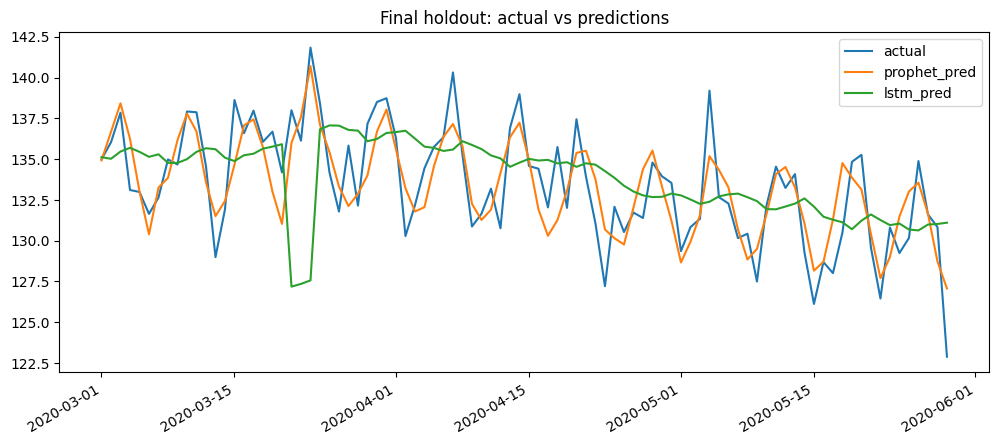

In [55]:
# Cell 14: plot final holdout predictions
import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
plt.plot(test_df['ds'], test_df['y'], label='actual')
plt.plot(test_df['ds'], yhat_prop, label='prophet_pred')
plt.plot(test_df['ds'], yhat_lstm, label='lstm_pred')
plt.title('Final holdout: actual vs predictions')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.show()


